example executive summary [here](https://www.proposify.biz/blog/executive-summary)

In [24]:
import requests
import pandas as pd
import numpy as np

# Import train test split
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Import CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

#import confusion matrix fxn
from sklearn.metrics import confusion_matrix, plot_roc_curve

In [3]:
url = 'https://api.pushshift.io/reddit/search/submission'

In [4]:
# collect multiple api pulls for "stocks" subreddit
df = []
params = {
        'size': 100,
        'subreddit': 'stocks'
    }
data = requests.get(url,params).json()
df.append(pd.DataFrame(data['data']))

for i in range(10):
    params['before'] = min(df[-1]['created_utc'])
    data = requests.get(url,params).json()
    df.append(pd.DataFrame(data['data']))
    
df_stocks = pd.concat(df,ignore_index=True)

In [5]:
# collect multiple api pulls for "StockMarket" subreddit
df = []
params = {
        'size': 100,
        'subreddit': 'StockMarket'
    }
data = requests.get(url,params).json()
df.append(pd.DataFrame(data['data']))

for i in range(10):
    params['before'] = min(df[-1]['created_utc'])
    data = requests.get(url,params).json()
    df.append(pd.DataFrame(data['data']))
    
df_stockm = pd.concat(df,ignore_index=True)

In [6]:
corpus_stocks = df_stocks['title'].unique()

In [7]:
corpus_stockm = df_stockm['title'].unique()

#### 1. Engineer a feature to turn `source_feature` into a 1/0 column, where 1 indicates `stocks` subreddit.

In [8]:
# create a combined df using UNIQUE title and if stocks = 1 StockMarket = 0
d1 = {'title' : df_stocks['title'].unique(), 'stocks' : 1}
d2 = {'title' : df_stockm['title'].unique(), 'stocks' : 0}

df = pd.concat([pd.DataFrame(data=d1),pd.DataFrame(data=d2)],ignore_index=True)

In [9]:
df['stocks'].value_counts()

1    1065
0    1051
Name: stocks, dtype: int64

In [109]:
# create csv for future use
df.to_csv('data.csv',index=False)

In [110]:
df = pd.read_csv('data.csv')

#### 2. Split our data into `X` and `y`.

In [10]:
X = df[['title']]
y = df['stocks']

#### 3. Split our data into training and testing sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

#### 4. Turn our text into features. [Documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [12]:
# Instantiate our CountVectorizer.
cvec = CountVectorizer(max_features = 500, stop_words = 'english')
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(),
                          columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title']).todense(),
                         columns = cvec.get_feature_names())

#### 4.1 Fit a Naive Bayes model!

In [13]:
from sklearn.naive_bayes import MultinomialNB

In [14]:
nb = MultinomialNB()
model = nb.fit(X_train_cvec, y_train)
predictions = model.predict(X_test_cvec)
model.score(X_train_cvec, y_train)

0.6893509766855702

In [15]:
model.score(X_test_cvec, y_test)

0.5671077504725898

In [16]:
print(confusion_matrix(y_test, predictions))
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

[[123 140]
 [ 89 177]]
True Negatives: 123
False Positives: 140
False Negatives: 89
True Positives: 177


#### 4.2 Fit a Random Forest model!

In [17]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
np.random.seed(42)

In [18]:
rf = RandomForestClassifier(n_estimators=100)
et = ExtraTreesClassifier(n_estimators=100)
print(f'rf: {cross_val_score(rf, X_train_cvec, y_train, cv=5).mean()}')
print(f'ef: {cross_val_score(et, X_train_cvec, y_train, cv=5).mean()}')

rf: 0.570257722754598
ef: 0.5727734460250382


In [19]:
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 5,10,20],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_cvec, y_train)
print(gs.best_score_)
gs.best_params_

0.5822292323869611


{'max_depth': 10, 'n_estimators': 200}

In [20]:
print(gs.score(X_train_cvec, y_train))
print(gs.score(X_test_cvec, y_test))

0.6969124133585382
0.5519848771266541


In [21]:
predictions = gs.predict(X_test_cvec)
print(confusion_matrix(y_test, predictions))
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

[[ 71 192]
 [ 45 221]]
True Negatives: 71
False Positives: 192
False Negatives: 45
True Positives: 221


#### 5. Visualisations
1. AUC  
2. RANDOM FOREST, FEATURE IMPORTANCE 
3. WORD CLOUD 
4. WORD FREQUENCY (TOP X WORDS) 
5. DECISION TREE, TREE VIZ

##### 5.1 AUC

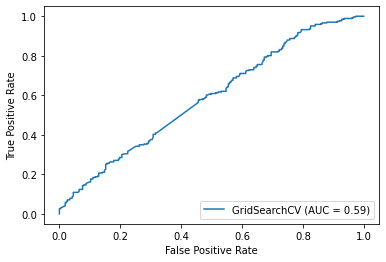

In [27]:
rf = plot_roc_curve(gs, X_test_cvec, y_test)

##### 5.2 Random Forest Importance

In [75]:
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

[i for i in X_test_cvec.columns]
start_time = time.time()
result = permutation_importance(
    gs, X_test_cvec, y_test, n_repeats=10, random_state=42, n_jobs=-1)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 111.607 seconds


In [90]:
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_import_20_abs = forest_importances.sort_values(key=lambda x: abs(x)).tail(20)
forest_import_20_pos = forest_importances.sort_values().tail(20)
forest_import_20_neg = forest_importances.sort_values().head(20)

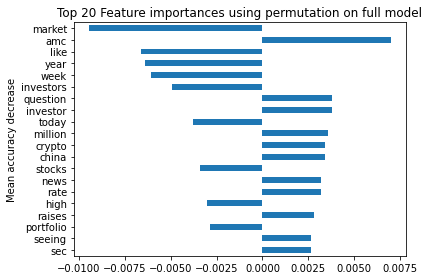

In [91]:
fig, ax = plt.subplots()
forest_import_20_abs.plot.barh(ax=ax)
ax.set_title("Top 20 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

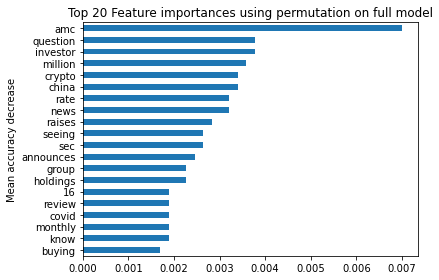

In [92]:
fig, ax = plt.subplots()
forest_import_20_pos.plot.barh(ax=ax)
ax.set_title("Top 20 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

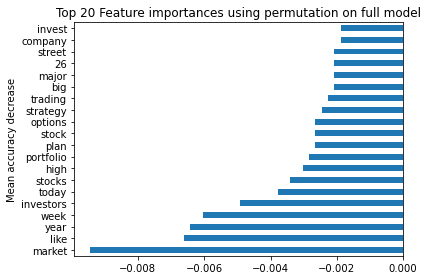

In [93]:
fig, ax = plt.subplots()
forest_import_20_neg.plot.barh(ax=ax)
ax.set_title("Top 20 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

We expect the difference to be positive, but in the cases of a negative number, it denotes that the random permutation worked better. It can be inferred that the variable does not have a role in the prediction,i.e, not important.

##### 5.3 Word Cloud

In [98]:
# !pip install wordcloud

     |████████████████████████████████| 220 kB 11.3 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158420 sha256=bc6ab1472715b1db6fc56db0dfecdea2e23a93d949418380dc5afa41d7219133
  Stored in directory: /Users/Ju/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built wordcloud


In [99]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [103]:
?WordCloud

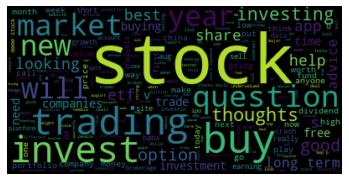

In [107]:
# Generate wordcloud for stocks subreddit
text = ' '.join(corpus_stocks.tolist()).lower()
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

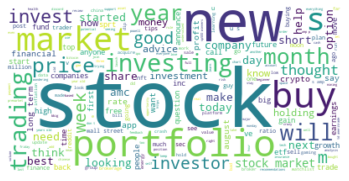

In [112]:
# Generate wordcloud for StockMarket subreddit
text = ' '.join(corpus_stockm.tolist()).lower()
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### 5.4 Word Frequency (TOP 20 WORDS)

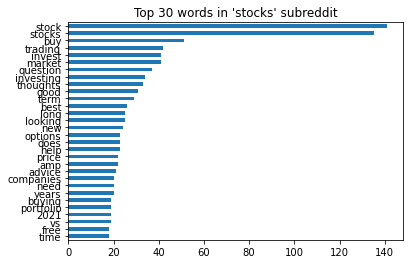

In [150]:
stocks_top_words = pd.DataFrame(cvec.fit_transform(corpus_stocks).todense(),
                          columns = cvec.get_feature_names())

fig, ax = plt.subplots()
stocks_top_words.sum().sort_values().tail(30).plot.barh(ax=ax)
ax.set_title("Top 30 words in 'stocks' subreddit")
plt.show();

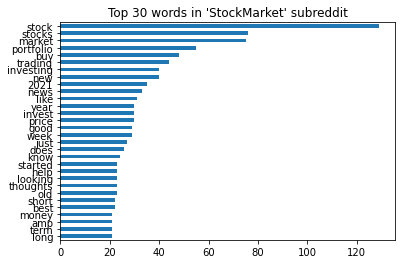

In [151]:
stockm_top_words = pd.DataFrame(cvec.fit_transform(corpus_stockm).todense(),
                          columns = cvec.get_feature_names())

fig, ax = plt.subplots()
stockm_top_words.sum().sort_values().tail(30).plot.barh(ax=ax)
ax.set_title("Top 30 words in 'StockMarket' subreddit")
plt.show();

###### 5.5 DECISION TREE, TREE VIZ

In [181]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [165]:
gs.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [167]:
rf = RandomForestClassifier(n_estimators=200, 
                            max_depth=10)
rf.fit(X_train_cvec,y_train)

RandomForestClassifier(max_depth=10, n_estimators=200)

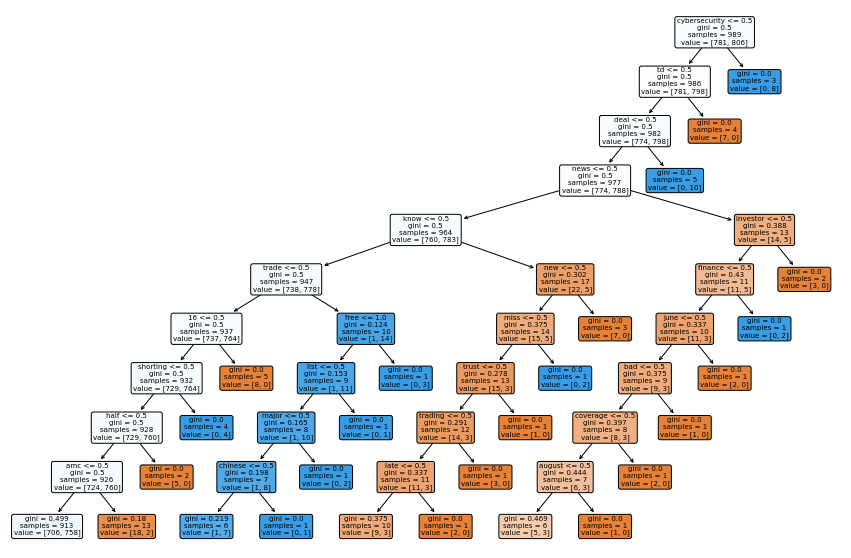

In [180]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0], 
          feature_names=X_train_cvec.columns,
          filled=True, impurity=True, 
          rounded=True);